In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys, os, pathlib
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import pandas as pd
import nibabel as nib
import torch

sys.path.append('../..')
import project

torch.cuda.is_available()

/ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp/lib/python3.11/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


True

In [3]:
# nb configuration
data_root = pathlib.Path('/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene')
data_file = data_root / 'sample1000_2025-07-22.csv'
fixed_state  = 'EXP'
moving_state = 'INSP'

In [4]:
df = pd.read_csv(data_file, sep='\t', low_memory=False)
df

sid ccenter kernel  Emphysema  pctEmph  pctEmph_Slicer  FEV1pp_utah  \
0    16514P     TEM    STD          0   0.3373          0.3147         77.6   
1    20748Q     UAB    STD          0   3.6045          3.4085         73.2   
2    11007Z     USD    STD          0   0.3126          0.2867         66.7   
3    14771Z     HPR    STD          0   0.3160          0.2948         94.1   
4    13651K     UIA    STD          0   2.0807          1.9551         85.1   
..      ...     ...    ...        ...      ...             ...          ...   
995  20519B     DUK    STD          1  30.1942         29.6440         19.9   
996  12294H     UAB    STD          1  40.3908         39.5845         43.3   
997  23123R     TEM    STD          0  23.6838         22.7617         42.8   
998  16546C     UIA    STD          1  42.6116         41.8307         58.6   
999  11099E     TXS    STD          0  28.6031         28.0289         52.3   

     FVCpp_utah  FEV1_FVC_utah  finalGold catEmph  
0          88.9           0.71       -1.0  normal  
1          75.8           0.75       -1.0  normal  
2         108.0           0.47        2.0  normal  
3          97.0           0.73        0.0  normal  
4          88.0           0.75        0.0  normal  
..          ...            ...        ...     ...  
995        69.2           0.22        4.0  severe  
996        86.0           0.37        3.0  severe  
997        72.7           0.45        3.0  severe  
998        99.6           0.43        2.0  severe  
999        96.0           0.41        2.0  severe  

[1000 rows x 11 columns]

In [76]:
%autoreload
ds = project.datasets.copdgene.COPDGeneDataset(data_root)

ex = list(ds.examples(
    subjects=['16514P'],
    visits=['Phase-1'],
    state_pairs=[('EXP', 'INSP')]
))[0]

def print_example(ex):
    for k, v in vars(ex).items():
        if isinstance(v, dict):
            print(f'{k.ljust(12)}')
            for vk, vv in v.items():
                print(f'    {repr(vk).ljust(15)} : {repr(vv)}')
        else:   
            print(f'{k.ljust(12)} : {repr(v)}')

print_example(ex)

dataset      : 'COPDGene'
subject      : '16514P'
visit        : 'Phase-1'
variant      : 'ISO'
fixed_state  : 'EXP'
moving_state : 'INSP'
paths       
    'ref_image'     : PosixPath('/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/16514P/Phase-1/RAW/16514P_EXP_STD_TEM_COPD.nii.gz')
    'fixed_source'  : PosixPath('/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/16514P/Phase-1/RAW/16514P_EXP_STD_TEM_COPD.nii.gz')
    'moving_source' : PosixPath('/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/16514P/Phase-1/RAW/16514P_INSP_STD_TEM_COPD.nii.gz')
    'fixed_image'   : PosixPath('/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/16514P/Phase-1/ISO/16514P_EXP_STD_TEM_COPD.nii.gz')
    'moving_image'  : PosixPath('/ocean/projects/asc170022p/mtragoza/lung-project/data/COPDGene/Images/16514P/Phase-1/ISO/16514P_INSP_STD_TEM_COPD.nii.gz')
    'fixed_mask'    : PosixPath('/ocean/projects/asc170022p/mtragoza/lu

In [7]:
%autoreload

def get_header_info(nifti):
    shape = np.asarray(nifti.header.get_data_shape())
    zooms = np.asarray(nifti.header.get_zooms())

    steps = nifti.affine[:3,:3].copy()
    origin = nifti.affine[:3,3].copy()
    axcodes = nib.orientations.aff2axcodes(nifti.affine)

    center_ijk = (shape[:3] - 1) / 2
    center_xyz = project.core.transforms.voxel_to_world_coords(center_ijk[None,:], nifti.affine)[0]

    # compute bbox of voxel centers from corner voxels
    i_bounds = [0, shape[0] - 1]
    j_bounds = [0, shape[1] - 1]
    k_bounds = [0, shape[2] - 1]
    I, J, K = np.meshgrid(i_bounds, j_bounds, k_bounds, indexing='ij')
    corners_ijk = np.stack([I, J, K], axis=-1).reshape(-1, 3)
    corners_xyz = project.core.transforms.voxel_to_world_coords(corners_ijk, nifti.affine)
    
    bbox_min = corners_xyz.min(axis=0)
    bbox_max = corners_xyz.max(axis=0)
    lengths = (shape - 1) * zooms

    return {
        'shape': tuple(shape),
        'zooms': tuple(zooms),
        'axcodes': axcodes,
        'origin': tuple(origin),
        'center': tuple(center_xyz),
        'steps': steps,
        'bbox_min': tuple(bbox_min),
        'bbox_max': tuple(bbox_max),
        'lengths': tuple(lengths)
    }

def get_center(image):
    size = np.array(image.GetSize(), dtype=int)
    spacing = np.array(image.GetSpacing(), dtype=float)
    origin = np.array(image.GetOrigin(), dtype=float)
    D = np.array(image.GetDirection(), dtype=float).reshape(3, 3)
    return origin + D @ (spacing * (size - 1) / 2)


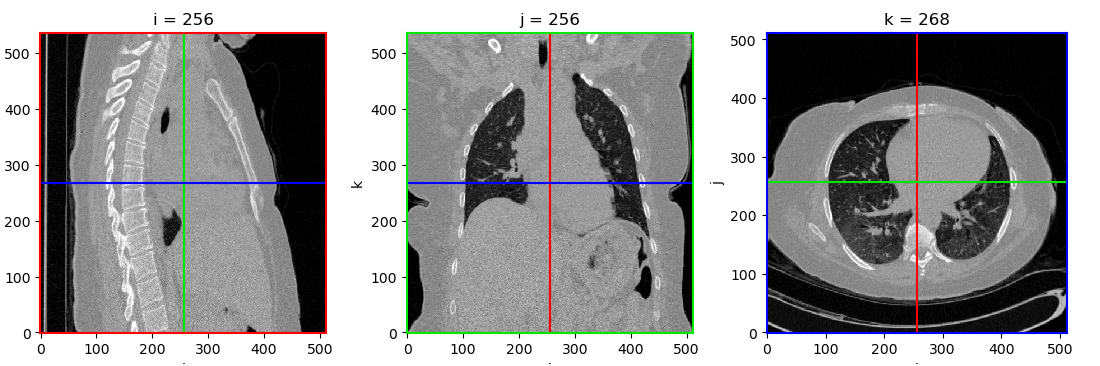

In [21]:
%autoreload
fixed_source = project.core.fileio.load_image(ex.paths['fixed_source'])
project.visual.matplotlib.show_image_slices(
    fixed_source.get_fdata(), imshow_kws=dict(cmap='Greys_r', vmin=-1000, vmax=1000)
)

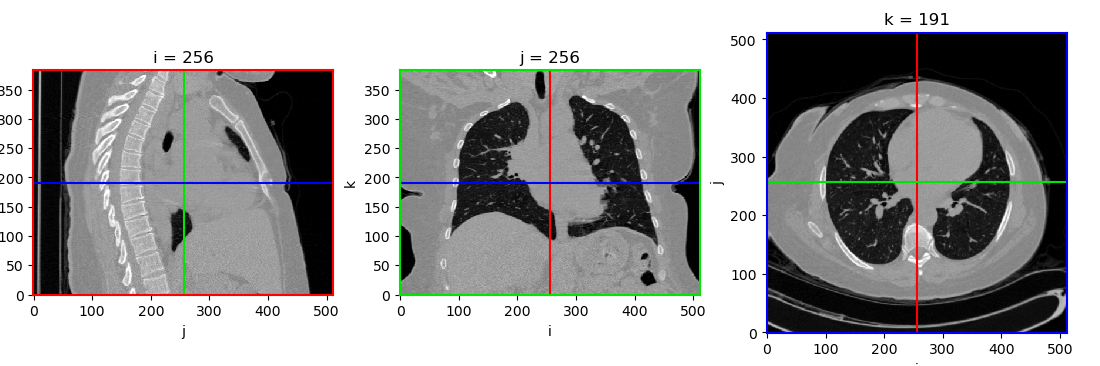

In [23]:
moving_source = project.core.fileio.load_image(ex.paths['moving_source'])
project.visual.matplotlib.show_image_slices(
    moving_source.get_fdata(), imshow_kws=dict(cmap='Greys_r', vmin=-1000, vmax=1000)
)

# Preprocessing

In [48]:
%autoreload
project.preprocessing.api.resample_image_on_reference(
    input_path=ex.paths['fixed_source'],
    output_path=ex.paths['fixed_image'],
    ref_path=ex.paths['ref_image']
)

Creating reference grid
Resampling image on grid


In [49]:
%autoreload
project.preprocessing.api.resample_image_on_reference(
    input_path=ex.paths['moving_source'],
    output_path=ex.paths['moving_image'],
    ref_path=ex.paths['ref_image']
)

Creating reference grid
Resampling image on grid


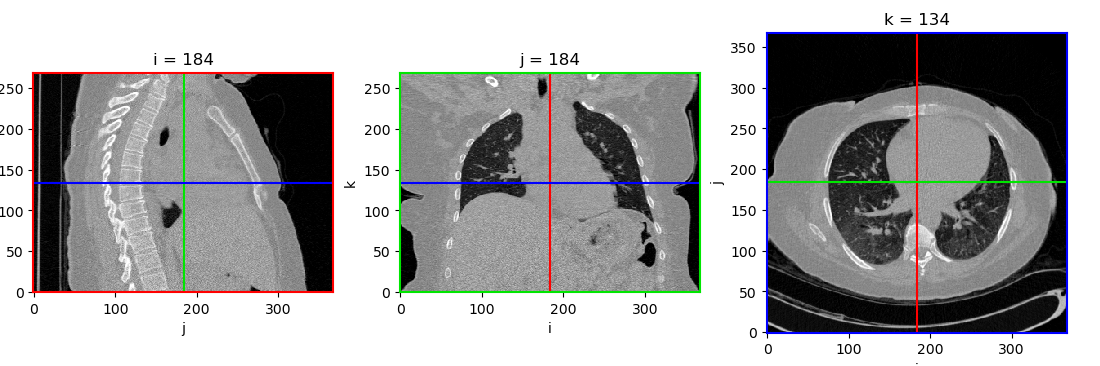

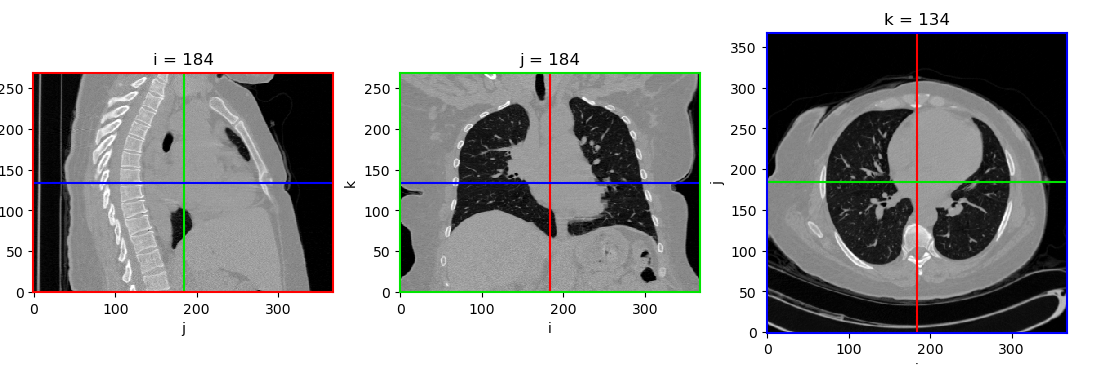

In [24]:
fixed_image = project.core.fileio.load_image(ex.paths['fixed_image'])
moving_image = project.core.fileio.load_image(ex.paths['moving_image'])

project.visual.matplotlib.show_image_slices(
    fixed_image.get_fdata(),
    imshow_kws=dict(cmap='Greys_r', vmin=-1000, vmax=1000)
)
project.visual.matplotlib.show_image_slices(
    moving_image.get_fdata(),
    imshow_kws=dict(cmap='Greys_r', vmin=-1000, vmax=1000)
)

In [52]:
%autoreload
project.preprocessing.api.create_segmentation_masks(
    image_path=ex.paths['fixed_image'],
    output_dir=ex.paths['fixed_mask'].parent
)

Running TotalSegmentator task: total

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough segmentation for cropping...
Resampling...
  Resampled in 0.87s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/inference/predict_from_raw_data.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

  Predicted in 8.27s
Resampling...
  cropping from (368, 368, 269) to (278, 224, 229)
Resampling...
  Resampled in 1.58s
Predicting part 1 of 1 ...


100%|██████████| 8/8 [00:00<00:00, 31.01it/s]


  Predicted in 10.01s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 1.96s
Running TotalSegmentator task: lung_vessels

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough segmentation for cropping...
Resampling...
  Resampled in 0.87s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/inference/predict_from_raw_data.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

  Predicted in 8.28s
Resampling...
  cropping from (368, 368, 269) to (278, 224, 229)
Predicting...


100%|██████████| 60/60 [00:03<00:00, 18.31it/s]


  Predicted in 27.33s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 1.52s


In [54]:
%autoreload
project.preprocessing.api.create_multi_region_mask(
    mask_dir=ex.paths['fixed_mask'].parent,
    output_path=ex.paths['fixed_mask']
)

Processing segmentation mask: lung_upper_lobe_right
  # 1-connected inputs components: 4
    72 voxels were dropped (0.0168%)
  # 1-connected output components: 1
Processing segmentation mask: lung_middle_lobe_right
  # 1-connected inputs components: 1
    0 voxels were dropped (0.0000%)
  # 1-connected output components: 1
Processing segmentation mask: lung_lower_lobe_right
  # 1-connected inputs components: 5
    15 voxels were dropped (0.0031%)
  # 1-connected output components: 1
Processing segmentation mask: lung_upper_lobe_left
  # 1-connected inputs components: 2
    2 voxels were dropped (0.0004%)
  # 1-connected output components: 1
Processing segmentation mask: lung_lower_lobe_left
  # 1-connected inputs components: 2
    4 voxels were dropped (0.0009%)
  # 1-connected output components: 1
Processing segmentation mask: lung_trachea_bronchia
  # 1-connected inputs components: 29
    50 voxels were dropped (0.3116%)
  # 1-connected output components: 6
Processing segmentation m

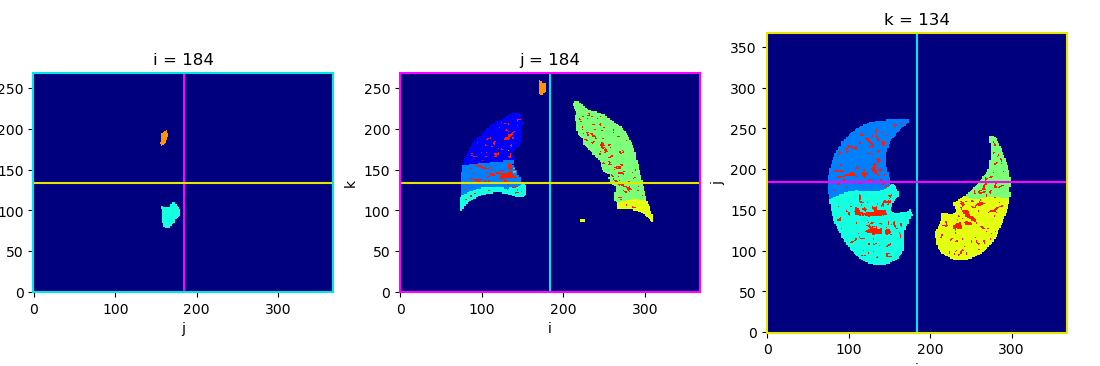

In [25]:
fixed_mask = project.core.fileio.load_image(ex.paths['fixed_mask'])

project.visual.matplotlib.show_image_slices(
    fixed_mask.get_fdata(),
    imshow_kws=dict(cmap='jet', vmin=0, vmax=8),
    colors='cmy'
)

In [27]:
%autoreload
project.preprocessing.api.create_anatomical_mesh(
    mask_path=ex.paths['fixed_mask'],
    output_path=ex.paths['fixed_mesh']
)

Removed 0 unused points
Final mesh:  <meshio mesh object>
  Number of points: 17330
  Number of cells:
    triangle: 61698
    tetra: 88047
  Cell data: label
Mesh has 1 connected component(s)
Done


In [78]:
%autoreload
fixed_mesh = project.core.fileio.load_mesh(ex.paths['fixed_mesh'])
fixed_mesh

<meshio mesh object>
  Number of points: 17330
  Number of cells:
    tetra: 88047
  Cell data: label

In [79]:
import pyvista as pv
pv_mesh = pv.from_meshio(fixed_mesh)
pl = pv.Plotter()
pl.add_mesh(pv_mesh, scalars='label', cmap='Set1', clim=(0,8))
pl.show()

2025-10-12 13:41:47.752 (1382.778s) [    154AACDB1200]vtkXOpenGLRenderWindow.:1416  WARN| bad X server connection. DISPLAY=


Widget(value='<iframe id="pyvista-jupyter_trame__template_P_0x1549af48f590_0" src="https://ondemand.bridges2.p…

In [85]:
%autoreload
project.preprocessing.api.create_corrfield_displacement(
    fixed_path=ex.paths['fixed_image'],
    moving_path=ex.paths['moving_image'],
    mask_path=ex.paths['fixed_mask'],
    output_path=ex.paths['disp_field']
)

Compute fixed MIND features ... 

/ocean/projects/asc170022p/mtragoza/mambaforge/envs/warp/lib/python3.11/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538435607/work/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


finished (13.84 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.26 s).
    2061 fixed keypoints extracted (0.41 s).
    Compute forward marginals ... 

/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/copdgene/../../corrfield/graphs.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538435607/work/torch/csrc/utils/tensor_new.cpp:278.)
  edges = torch.tensor(


finished (4.17 s).
    Compute symmetric backward marginals ... finished (1.54 s).
    Dense thin plate spline interpolation ... finished (28.73 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.21 s).
    4050 fixed keypoints extracted (0.30 s).
    Compute forward marginals ... finished (1.00 s).
    Compute symmetric backward marginals ... finished (0.97 s).
    Dense thin plate spline interpolation ... finished (1.29 s).

tensor(0.3913, device='cuda:0') tensor(0.2225, device='cuda:0')
Done


# Visualization

In [95]:
vars(nib.load(ex.paths['disp_field']))

{'_header': <nibabel.nifti1.Nifti1Header at 0x154975319d50>,
 'extra': {},
 'file_map': {'image': <nibabel.fileholders.FileHolder at 0x1549753181d0>},
 '_dataobj': <nibabel.arrayproxy.ArrayProxy at 0x15497531ac10>,
 '_data_cache': None,
 '_fdata_cache': None,
 '_affine': array([[  -1. ,   -0. ,    0. ,  167.5],
        [  -0. ,    1. ,   -0. ,   -6.5],
        [   0. ,    0. ,    1. , -319. ],
        [   0. ,    0. ,    0. ,    1. ]]),
 '_load_cache': {'header': <nibabel.nifti1.Nifti1Header at 0x15497613bd50>,
  'affine': array([[  -1. ,   -0. ,    0. ,  167.5],
         [  -0. ,    1. ,   -0. ,   -6.5],
         [   0. ,    0. ,    1. , -319. ],
         [   0. ,    0. ,    0. ,    1. ]]),
  'file_map': {'image': <nibabel.fileholders.FileHolder at 0x15497531ab50>}}}

In [41]:
source_image = visit.load_image(variant='ISO', state=source_state, recon='STD')
target_image = visit.load_image(variant='ISO', state=target_state, recon='STD')

mask_image_s = visit.load_mask(variant='ISO', state=source_state, recon='STD', mask_name='lung_regions')
mask_image_t = visit.load_mask(variant='ISO', state=target_state, recon='STD', mask_name='lung_regions')

disp_image = visit.load_displacement_field(
    variant='ISO', target_state=target_state, source_state=source_state, recon='STD'
)
source_mesh = visit.load_mesh(
    variant='ISO', state=source_state, recon='STD', mask_name='lung_regions', mesh_tag='surface'
)
target_mesh = visit.load_mesh(
    variant='ISO', state=target_state, recon='STD', mask_name='lung_regions', mesh_tag='surface'
)

In [42]:
source_array = source_image.get_fdata()
target_array = target_image.get_fdata()

mask_array_s = mask_image_s.get_fdata()
mask_array_t = mask_image_t.get_fdata()

disp_array = disp_image.get_fdata()

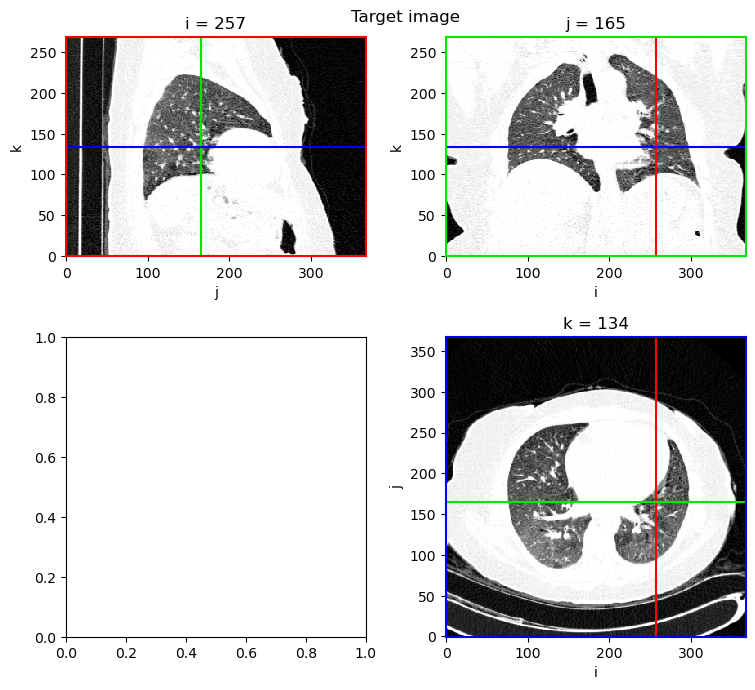

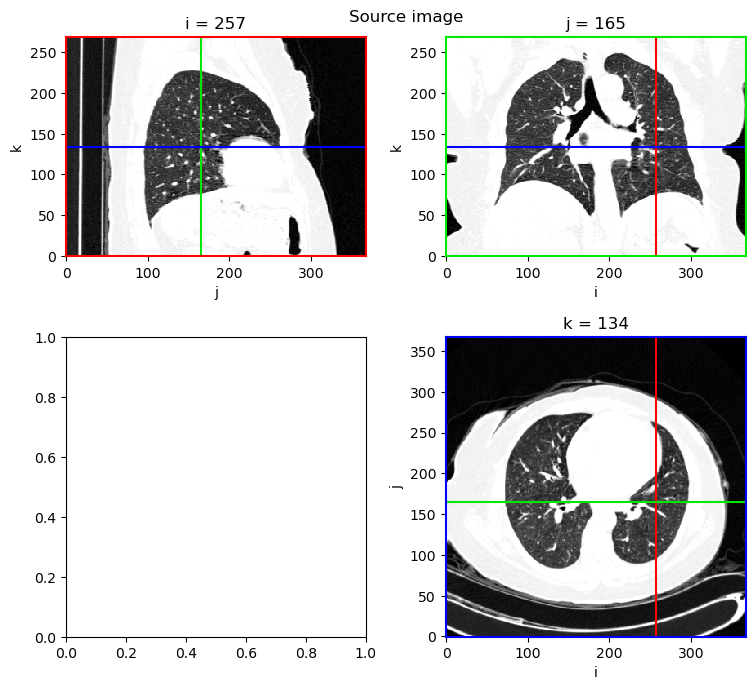

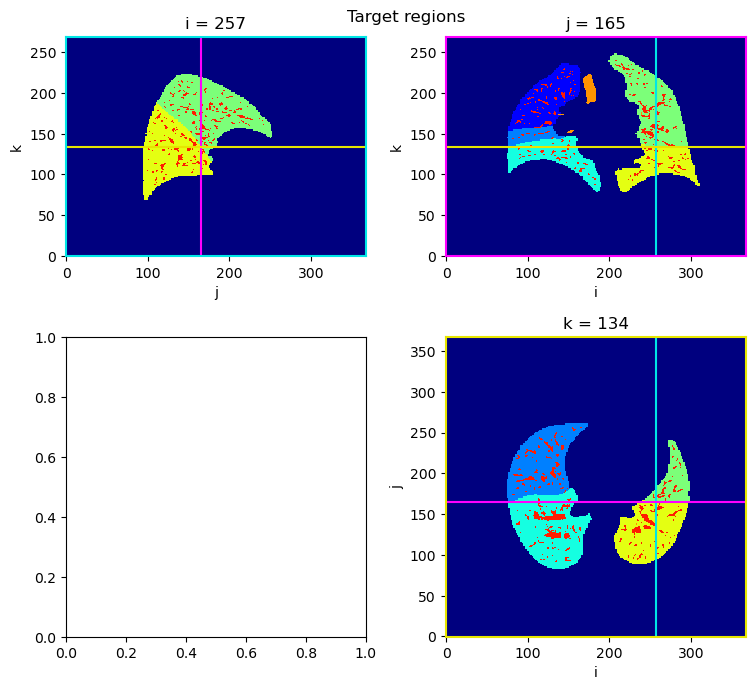

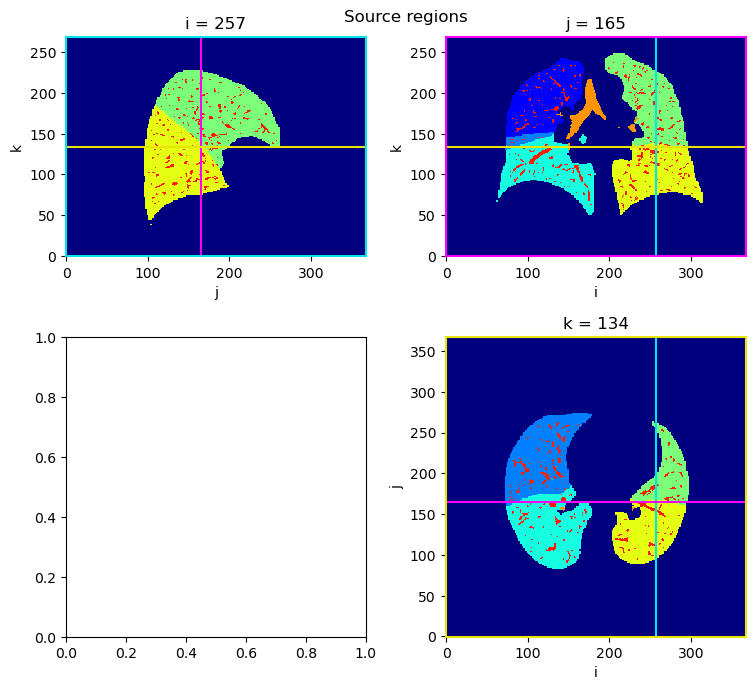

In [44]:
idx = (0.7, 0.45, 0.5)
show_image_slices(target_array, idx, imshow_kws=dict(cmap='Greys_r', vmin=-1024, vmax=0), title='Target image', colors='rgb')
show_image_slices(source_array, idx, imshow_kws=dict(cmap='Greys_r', vmin=-1024, vmax=0), title='Source image', colors='rgb')
show_image_slices(mask_array_t, idx, imshow_kws=dict(cmap='jet', vmin=0, vmax=8), title='Target regions', colors='cmy')
show_image_slices(mask_array_s, idx, imshow_kws=dict(cmap='jet', vmin=0, vmax=8), title='Source regions', colors='cmy')

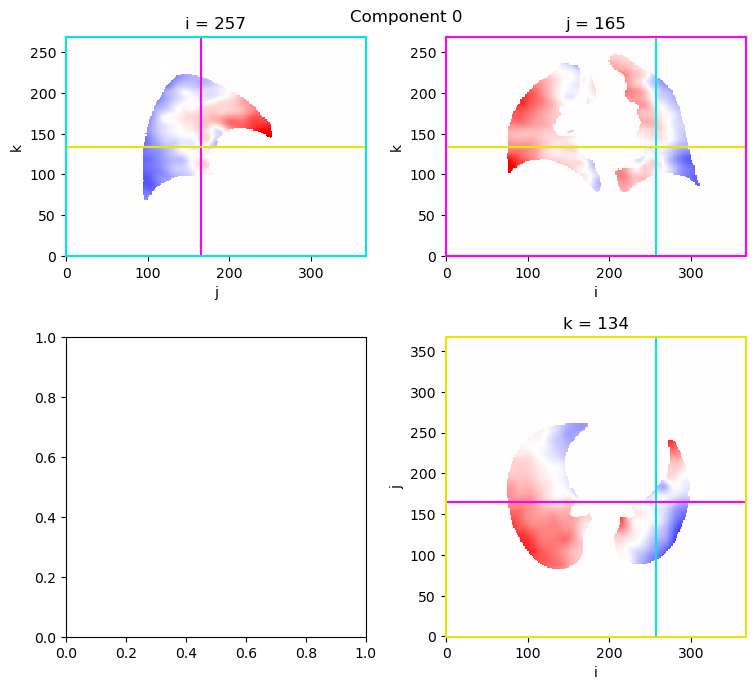

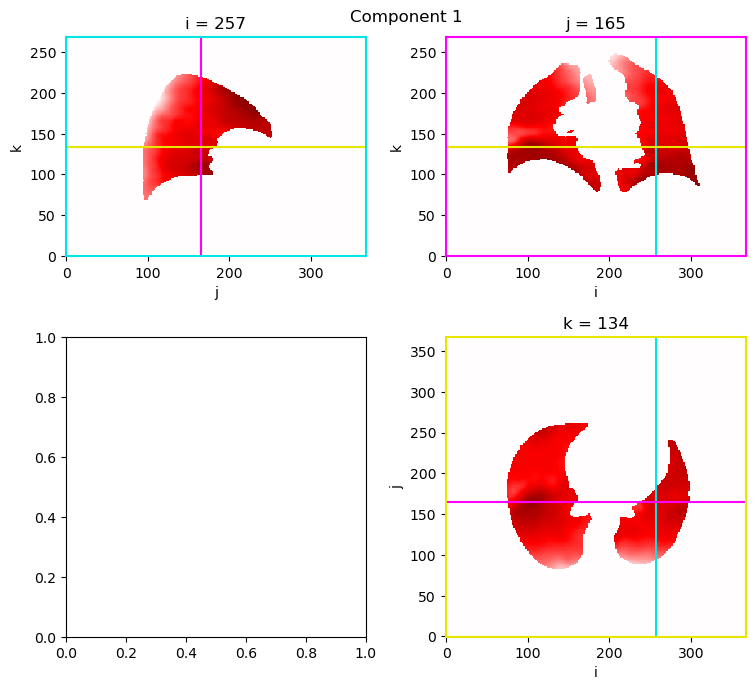

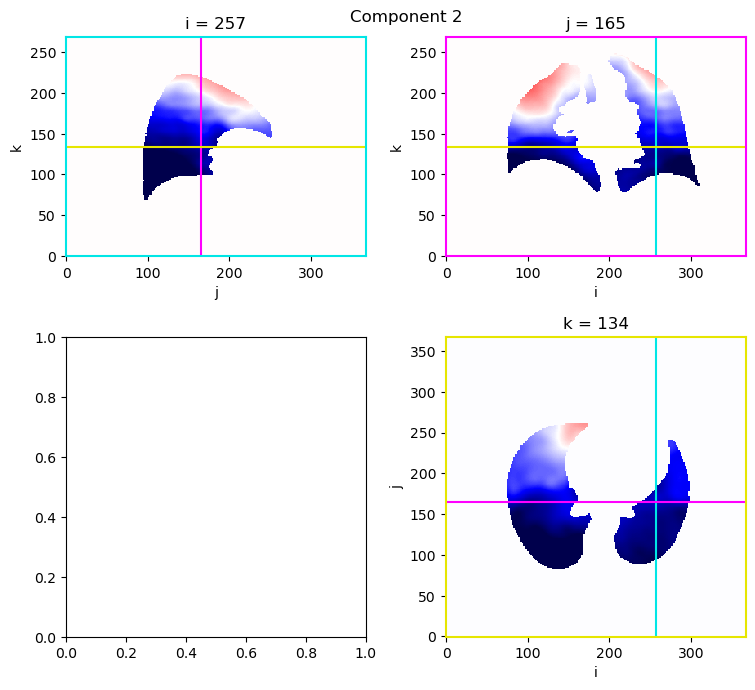

In [45]:
alpha = 1
m = (mask_array_t > 0) * alpha + (1 - alpha)
show_image_slices(disp_array[...,0] * m, idx, imshow_kws=dict(cmap='seismic', vmin=-20, vmax=20), title='Component 0', colors='cmy')
show_image_slices(disp_array[...,1] * m, idx, imshow_kws=dict(cmap='seismic', vmin=-20, vmax=20), title='Component 1', colors='cmy')
show_image_slices(disp_array[...,2] * m, idx, imshow_kws=dict(cmap='seismic', vmin=-20, vmax=20), title='Component 2', colors='cmy')

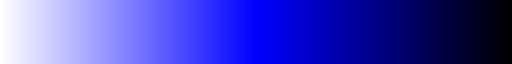

In [61]:
import matplotlib

nneg_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    name='nonnegative',
    colors=[
        (1,1,1),
        (0,0,1),
        (0,0,0),
    ]
)
nneg_cmap.set_under('red')
nneg_cmap

lungs:   282.97998046875
airways: 33.13043212890621
vessels: 643.5667724609375


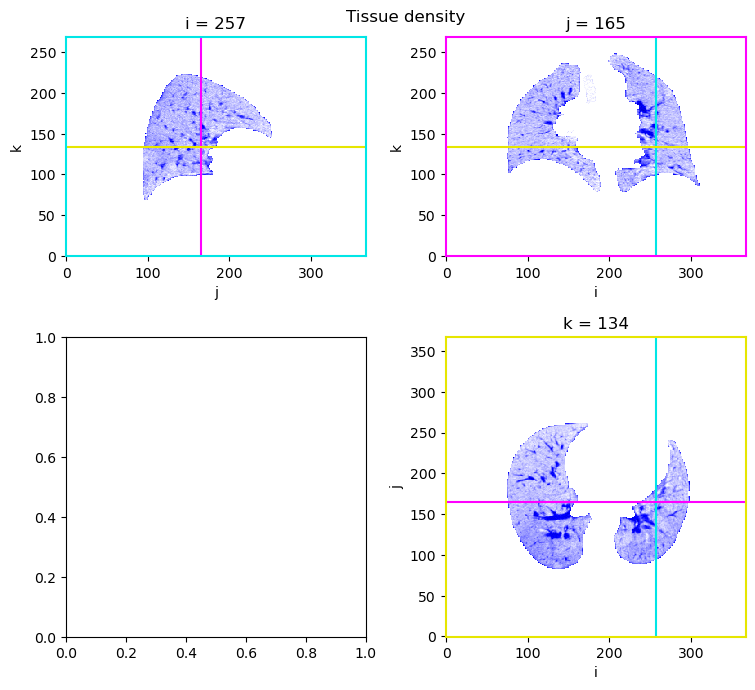

In [74]:
%autoreload

density_array = project.segmentation.compute_density_map(target_array, mask_array_t, use_ct=1, use_mask=0)

alpha = 1
m = (mask_array_t > 0) * alpha + (1 - alpha)

show_image_slices(density_array * m, idx, imshow_kws=dict(cmap=nneg_cmap, vmin=0, vmax=2000), title='Tissue density', colors='cmy')